In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../Data/Pharmacy/D5.csv')

In [3]:
df.head()

,date,itemname,packunits,expiry,price,looseqty
0,01/07/2022,PANADOL TAB,200,4/25/24,1.70,60
1,02/07/2022,PANADOL TAB,200,4/25/24,1.70,70
2,03/07/2022,PANADOL TAB,200,4/25/24,1.70,55
3,05/07/2022,PANADOL TAB,200,4/25/24,1.45,20
4,08/07/2022,PANADOL TAB,200,4/25/24,1.70,70


In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.set_index('date', inplace=True)

In [5]:
target_variable = 'looseqty'
df = df[[target_variable]]

In [6]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [7]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [8]:
sequence_length = 10

In [9]:
sequences = create_sequences(df_scaled, sequence_length)

In [10]:
train_size = int(len(sequences) * 0.8)
train, test = sequences[:train_size], sequences[train_size:]

In [11]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
9/9 - 0s - loss: 0.0643 - val_loss: 0.1094 - 369ms/epoch - 41ms/step
Epoch 2/50
9/9 - 0s - loss: 0.0307 - val_loss: 0.0499 - 18ms/epoch - 2ms/step
Epoch 3/50
9/9 - 0s - loss: 0.0160 - val_loss: 0.0261 - 18ms/epoch - 2ms/step
Epoch 4/50
9/9 - 0s - loss: 0.0156 - val_loss: 0.0247 - 17ms/epoch - 2ms/step
Epoch 5/50
9/9 - 0s - loss: 0.0134 - val_loss: 0.0289 - 17ms/epoch - 2ms/step
Epoch 6/50
9/9 - 0s - loss: 0.0129 - val_loss: 0.0294 - 17ms/epoch - 2ms/step
Epoch 7/50
9/9 - 0s - loss: 0.0119 - val_loss: 0.0235 - 17ms/epoch - 2ms/step
Epoch 8/50
9/9 - 0s - loss: 0.0114 - val_loss: 0.0251 - 17ms/epoch - 2ms/step
Epoch 9/50
9/9 - 0s - loss: 0.0110 - val_loss: 0.0237 - 17ms/epoch - 2ms/step
Epoch 10/50
9/9 - 0s - loss: 0.0107 - val_loss: 0.0233 - 17ms/epoch - 2ms/step
Epoch 11/50
9/9 - 0s - loss: 0.0107 - val_loss: 0.0229 - 18ms/epoch - 2ms/step
Epoch 12/50
9/9 - 0s - loss: 0.0106 - val_loss: 0.0235 - 18ms/epoch - 2ms/step
Epoch 13/50
9/9 - 0s - loss: 0.0107 - val_loss: 0.0226 - 18

In [15]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 856us/step


In [16]:
y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]

In [17]:
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

In [18]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test_inv), np.log1p(y_pred_inv)))

In [19]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle}")

Root Mean Squared Error (RMSE): 137.2803728457543
Root Mean Squared Logarithmic Error (RMSLE): 0.32572063927800055


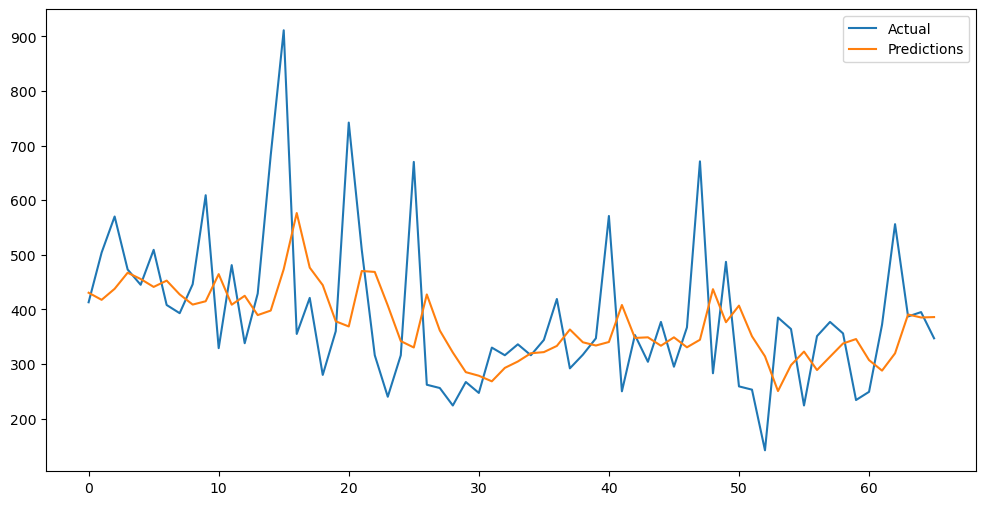

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predictions')
plt.legend()
plt.show()